In [125]:
import cv2
import imutils
import math
from math import atan2

import matplotlib
import numpy as np
from numpy import trapz
import pandas as pd
import seaborn as sns
import typing as tp

from scipy import spatial

from matplotlib import pyplot as plt

sns.set()
sns.set_style("whitegrid")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

In [144]:
class Video():
    
    def __init__(self, path, start=0, stop=math.inf) -> None:
        """
        Сохраняет (во внутреннюю переменную) последовательность масштабированных кадров с настроенной яркостью.
        Видео обрезается согласно номерам кадров start и stop при их указании.
        """
        def preprocessing(img, value=100):
            crop_img = img[0:img.shape[0], 
                           int((img.shape[1] - img.shape[0])/2):int((img.shape[1] - img.shape[0])/2 + img.shape[0])]
            out = cv2.convertScaleAbs(crop_img, alpha=1.3, beta=-150)
            return cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)
        
        self.frames = []
        vidcap = cv2.VideoCapture(path)
        success,image = vidcap.read()
        current_frame = 0
        begin = 0
        while success:
            if (stop >= current_frame >= start):
                if (np.sum(image)/(1023 * image.shape[0] * image.shape[1]) < 0.37 and begin == 1):
                    self.frames.append(preprocessing(image))
                elif (np.sum(image)/(1023 * image.shape[0] * image.shape[1]) >= 0.37 and begin == 0):
                    begin = 1
            success,image = vidcap.read()
            current_frame += 1
         
        
    def calculate(self, find_triangles: bool = False) -> None:
        """
        Сохраняет траектории роботов, а также изменения углов поворота относительно первоначального положения.
        find_triangles: необходимо ли искать углы.
        Полученные значения масштабируются в соответствии с real_radius в сантиметрах.
        """
        def euclidian_distance(vertex_0: np.ndarray, vertex_1: np.ndarray):
            return ((vertex_0[0] - vertex_1[0])**2 + (vertex_0[1] - vertex_1[1])**2)**0.5
        
        def control_vertex(vertex_0, vertex_1, vertex_2):
            rho_1 =  euclidian_distance(vertex_0, vertex_1)
            rho_2 =  euclidian_distance(vertex_1, vertex_2)
            rho_3 =  euclidian_distance(vertex_0, vertex_2)

            if (rho_1 < rho_2 and rho_1 < rho_3):
                return (2, 0, 1)
            elif (rho_2 < rho_1 and rho_2 < rho_3):
                return (0, 1 , 2)
            else:
                return (1, 0 , 2)
            
            
        def convert_to_triangle(vertexes: np.ndarray):
            min = [10005000, 0, 0]
            for i in range (0, len(vertexes)):
                for j in range (i+1, len(vertexes)):
                    if euclidian_distance(vertexes[i][0], vertexes[j][0]) < min[0]:
                        min = [euclidian_distance(vertexes[i][0], vertexes[j][0]), i, j]
            return np.delete(vertexes,  min[2], 0)
            
    
        def get_triangles(frame: np.ndarray, index: int):
            """
            Ищет треугольник на кадре
            """
            thresh = cv2.threshold(frame, 130, 255, cv2.THRESH_TOZERO)[1]
            (contours, _) = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            self.shapes.append([]);
            number_of_triangle = 0
            for i in range (0, len(contours)):
                if len(cv2.approxPolyDP(contours[i], 0.04 * cv2.arcLength(contours[i], True), True)) == 3:
                    if 3500 >= cv2.contourArea(contours[i]) >= 1000:
                        self.shapes[index].append([contours[i], cv2.approxPolyDP(contours[i], 0.04 * cv2.arcLength(contours[i], 
                                        True), True)])
                        vertexes = control_vertex(self.shapes[index][number_of_triangle][1][0][0], 
                                        self.shapes[index][number_of_triangle][1][1][0], 
                                        self.shapes[index][number_of_triangle][1][2][0])
                        center = (int((self.shapes[index][number_of_triangle][1][vertexes[1]][0][0] + 
                                        self.shapes[index][number_of_triangle][1][vertexes[2]][0][0])/2), 
                                  int((self.shapes[index][number_of_triangle][1][vertexes[1]][0][1] + 
                                        self.shapes[index][number_of_triangle][1][vertexes[2]][0][1])/2))
                        self.shapes[index][number_of_triangle].append(center)
                       
                        
                        if (find_triangles == True):
                            angle = atan2(self.shapes[index][number_of_triangle][1][vertexes[0]][0][0] - center[0], 
                                        self.shapes[index][number_of_triangle][1][vertexes[0]][0][1] - center[1])
                            self.shapes[index][number_of_triangle].append(angle)
                            
                        number_of_triangle += 1
                        
            
            
            if len(self.shapes[index]) < 3:
                for i in range (0, len(contours)):
                    if len(cv2.approxPolyDP(contours[i], 0.04 * cv2.arcLength(contours[i], True), True)) == 4:
                        if 3500 >= cv2.contourArea(contours[i]) >= 1000:
                            self.shapes[index].append([contours[i], cv2.approxPolyDP(contours[i], 0.04 * 
                                                                               cv2.arcLength(contours[i], True), True)])
                            self.shapes[index][number_of_triangle][1] = convert_to_triangle(self.shapes[index][number_of_triangle][1])

                            vertexes = control_vertex(self.shapes[index][number_of_triangle][1][0][0], 
                                                      self.shapes[index][number_of_triangle][1][1][0], 
                                                      self.shapes[index][number_of_triangle][1][2][0])
                            center = (int((self.shapes[index][number_of_triangle][1][vertexes[1]][0][0] + self.shapes[index][number_of_triangle][1][vertexes[2]][0][0])/2), 
                                  int((self.shapes[index][number_of_triangle][1][vertexes[1]][0][1] + self.shapes[index][number_of_triangle][1][vertexes[2]][0][1])/2))
                            self.shapes[index][number_of_triangle].append(center)
                            
                            
                            if (find_triangles == True):
                                angle = atan2(self.shapes[index][number_of_triangle][1][vertexes[0]][0][0] - center[0], 
                                          self.shapes[index][number_of_triangle][1][vertexes[0]][0][1] - center[1])
                                self.shapes[index][number_of_triangle].append(angle)
            
                            number_of_triangle += 1
            
            
            self.indicator.append([index, len(self.shapes[index])])
        
        def find_next_position(shape: np.ndarray, layer: np.ndarray):
            
            """
            Ищет следующее положение робота.
            """
            min = [100500, 0, 0, 0]
            for j in range (0, len(layer)):
                if (euclidian_distance(shape,layer[j][2]) < min[0]):
                    min = [euclidian_distance(shape,layer[j][2]), j, layer[j][2], layer[j][3]]
            return min
        
        
        self.shapes = []
        self.indicator = []
        for index in range (0, len(self.frames)):
            get_triangles(self.frames[index], index)
        
        
        
#        for index in range (0, len(self.frames)):
#            for c in range (0, len(self.shapes[index])):
#                cv2.drawContours(self.frames[index], self.shapes[index][c], 0, (255,128,0),3)
#                cv2.circle(self.frames[index], self.shapes[index][c][2], 5, (255,128,0), 3)
        
        self.trace = []
        
        for c in range (0, len(self.shapes[index])):
            self.trace.append([]);
            self.trace[c].append([0, self.shapes[0][c][2], self.shapes[0][c][3]])
            number = c
            distance = 0
            for index in range (0, len(self.frames)-1): 
                next_condition = find_next_position(self.shapes[index][number][2], self.shapes[index+1])
                number = next_condition[1]
                distance += next_condition[0]
                self.trace[c].append([distance, next_condition[2], next_condition[3]])
    
    
    
        
        for c in range (0, len(self.trace)):
            for index in range (0, len(self.frames)-1):
                cv2.circle(self.frames[index], self.trace[c][index][1], 5, (255,128,0), 3)
    
    def draw_frame(self, index: int) -> None:
        """
        Выводит на экран кадр с отображёнными на нём фигурами при их существовании.
        """
        pass
    
    def plot_trajectories(self, indices: tp.List[int] = None):
        """
        Строит траектории роботов с заданными индексами, либо всех.
        """
        pass
        
    def plot_median_distance(self, indices: tp.List[int] = None):
        """
        Строит зависимость среднего расстояния от центра от времени для роботов с заданными индексами.
        """
        pass
        
    def plot_angles(self) -> tp.Any:
        """
        """
        pass
    
    def save_to_csv(self, path: str) -> None:
        """
        Сохраняет известную информацию в csv.
        """
        pass

In [145]:
path = 'videos_test/1.mp4'
video = Video(path, 0, 1000)

In [146]:
len(video.frames)
video.calculate(True)

In [139]:
%debug

> <ipython-input-136-c05de0e59559>(160)calculate()
    158         for c in range (0, len(self.shapes[index])):
    159             for index in range (0, len(self.frames)-1):
--> 160                 cv2.circle(self.frames[index], self.trace[index][c][1], 5, (255,128,0), 3)
    161 
    162     def draw_frame(self, index: int) -> None:

ipdb> index
3
ipdb> self.trace[2]
[[0, (947, 630), -3.0940095503128098], [24.515301344262525, (952, 654), -3.1266683885997084], [44.4401601894338, (933, 660), -3.1169063115341937], [69.5200325974027, (923, 637), -3.115624466378237], [80.92178684839408, (914, 644), 2.958481836327309], [91.21741698938108, (905, 649), 2.7209293044567584], [98.21741698938108, (898, 649), 2.413822917669819], [120.14912918884238, (883, 665), 2.0988707752212563], [128.751454455885, (876, 670), 1.6718996985311951], [149.3669825839733, (860, 683), 1.3083369269686203], [173.13671123198273, (838, 692), 1.0918827282473107], [194.77001888476667, (820, 704), 0.5585993153435624], [218

ipdb> self.trace[3]
*** IndexError: list index out of range
ipdb> exit


In [143]:
video.trace[2][1]

[24.515301344262525, (952, 654), -3.1266683885997084]

In [122]:
ang = [[], [], []]
pos = [[], [], []]
dis = [[], [], []]
for c in range (0, len(video.trace)):
    ang[c] = np.array(video.trace[c])[:, 2]
    pos[c] = np.array(video.trace[c])[:, 1]
    dis[c] = np.array(video.trace[c])[:, 0]
T = range(0, len(video.trace[0]))

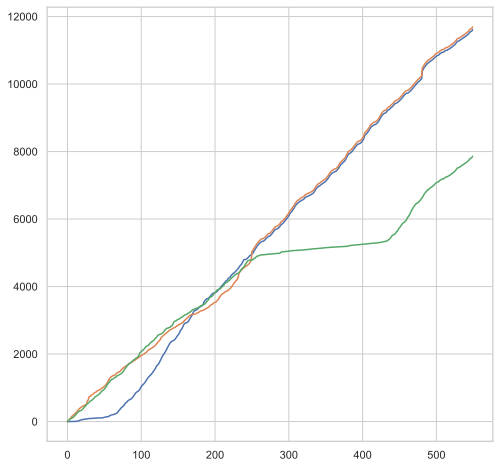

In [123]:
ax = plt.figure(figsize = (8, 8)).gca()
for c in range (0, len(video.trace)):
    plt.plot(T, dis[c], label = type)

plt.savefig("dist.svg")    

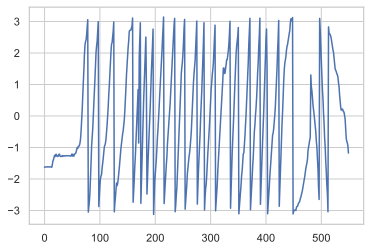

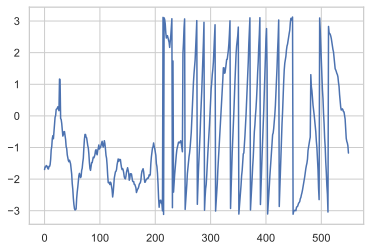

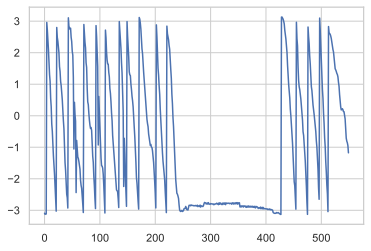

In [124]:

for c in range (0, len(video.trace)):
    plt.plot(T, ang[c])
    plt.savefig("angle" + str(c) +".svg")   
    plt.show()

In [67]:
F = [2:10]

SyntaxError: invalid syntax (<ipython-input-67-ad31bd0a8509>, line 1)

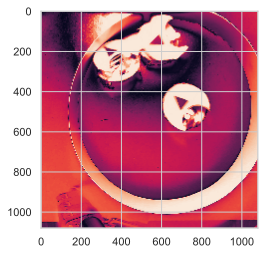

In [156]:
for c in range (0, len(video.frames)):
    plt.imshow(video.frames[c])
    plt.savefig("res/test" + str(c) + ".png")    

In [38]:
video.indicator

[[0, 3],
 [1, 3],
 [2, 3],
 [3, 3],
 [4, 3],
 [5, 3],
 [6, 3],
 [7, 3],
 [8, 3],
 [9, 3],
 [10, 5],
 [11, 4],
 [12, 3],
 [13, 3],
 [14, 3],
 [15, 3],
 [16, 3],
 [17, 3],
 [18, 3],
 [19, 3],
 [20, 3],
 [21, 3],
 [22, 3],
 [23, 3],
 [24, 3],
 [25, 3],
 [26, 3],
 [27, 3],
 [28, 4],
 [29, 3],
 [30, 3],
 [31, 3],
 [32, 3],
 [33, 3],
 [34, 3],
 [35, 3],
 [36, 3],
 [37, 3],
 [38, 3],
 [39, 3],
 [40, 3],
 [41, 3],
 [42, 3],
 [43, 3],
 [44, 3],
 [45, 4],
 [46, 3],
 [47, 3],
 [48, 3],
 [49, 3],
 [50, 3],
 [51, 3],
 [52, 3],
 [53, 3],
 [54, 4],
 [55, 4],
 [56, 3],
 [57, 4],
 [58, 3],
 [59, 4],
 [60, 3],
 [61, 3],
 [62, 3],
 [63, 3],
 [64, 3],
 [65, 3],
 [66, 3],
 [67, 3],
 [68, 3],
 [69, 3],
 [70, 3],
 [71, 3],
 [72, 4],
 [73, 4],
 [74, 4],
 [75, 3],
 [76, 3],
 [77, 3],
 [78, 3],
 [79, 3],
 [80, 4],
 [81, 3],
 [82, 3],
 [83, 3],
 [84, 3],
 [85, 3],
 [86, 3],
 [87, 3],
 [88, 3],
 [89, 3],
 [90, 3],
 [91, 3],
 [92, 4],
 [93, 3],
 [94, 3],
 [95, 3],
 [96, 3],
 [97, 4],
 [98, 3],
 [99, 3],
 [100, 3],

In [187]:
#img = cv2.cvtColor(cv2.imread('exact.png'), cv2.COLOR_BGR2GRAY)
img = video.frames[51]
thresh = cv2.threshold(img, 130, 255, cv2.THRESH_TOZERO)[1]

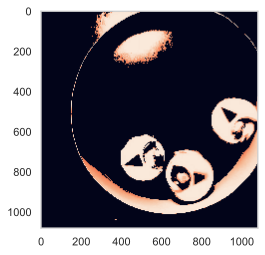

In [162]:
plt.rcParams["axes.grid"] = False
plt.imshow(thresh)

In [163]:
(contours, _) = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
shapes = []
vtg = 0
for contour in contours:
    if len(cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)) == 4:
        if 3500 >= cv2.contourArea(contour) >= 1000:
            vtg = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
            shapes.append([contour, cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)])
    

In [171]:
def convert_to_triangle(vertexes: np.ndarray):
    min = [10005000, 0, 0]
    for i in range (0, len(vertexes)):
        for j in range (i+1, len(vertexes)):
            if euclidian_distance(vertexes[i][0], vertexes[j][0]) < min[0]:
                min = [euclidian_distance(vertexes[i][0], vertexes[j][0]), i, j]
    return np.delete(vertexes, min[2], 0)

In [172]:
np.delete(shapes[0][1], 2, 0)

array([[[759, 810]],

       [[811, 818]],

       [[765, 862]]], dtype=int32)

In [173]:
convert_to_triangle(shapes[0][1])

array([[[759, 810]],

       [[811, 818]],

       [[765, 862]]], dtype=int32)

In [174]:
for c in range (0, len(shapes)):
    cv2.drawContours(img,shapes[c], 0, (255,128,0),3)

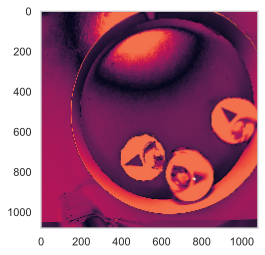

In [190]:
plt.imshow(img)

In [176]:
shapes[0][1] = convert_to_triangle(shapes[0][1])

In [178]:
def control_vertex(vertex_0, vertex_1, vertex_2):
    rho_1 =  euclidian_distance(vertex_0, vertex_1)
    rho_2 =  euclidian_distance(vertex_1, vertex_2)
    rho_3 =  euclidian_distance(vertex_0, vertex_2)

    if (rho_1 < rho_2 and rho_1 < rho_3):
        return (2, 0, 1)
    elif (rho_2 < rho_1 and rho_2 < rho_3):
        return (0, 1 , 2)
    else:
        return (1, 0 , 2)
    
def euclidian_distance(vertex_0: np.ndarray, vertex_1: np.ndarray):
    return ((vertex_0[0] - vertex_1[0])**2 + (vertex_0[1] - vertex_1[1])**2)**0.5

In [179]:
f = 0

In [180]:
#a = (int((shapes[2][1][vertexes[1]][0][0] + shapes[2][1][vertexes[2]][0][0])/2), int((shapes[2][1][vertexes[1]][0][1] + 
#                                             shapes[2][1][vertexes[2]][0][1])/2))
vertexes = control_vertex(shapes[f][1][0][0], shapes[f][1][1][0], shapes[f][1][2][0])
a = (int((shapes[f][1][vertexes[1]][0][0] + shapes[f][1][vertexes[2]][0][0])/2), int((shapes[f][1][vertexes[1]][0][1] + 
                                             shapes[f][1][vertexes[2]][0][1])/2))
a = (int((shapes[f][1][vertexes[1]][0][0] + shapes[f][1][vertexes[1]][0][0])/2), int((shapes[f][1][vertexes[1]][0][1] + 
                                             shapes[f][1][vertexes[1]][0][1])/2))

In [189]:

cv2.circle(img, a, 5, (255,128,0), 3)

array([[ 82,  72,  63, ..., 102, 104, 104],
       [ 77,  68,  60, ..., 102, 104, 104],
       [ 73,  65,  57, ..., 101, 103, 104],
       ...,
       [ 44,  42,  44, ...,  82,  84,  86],
       [ 44,  42,  44, ...,  86,  88,  88],
       [ 44,  42,  44, ...,  87,  90,  88]], dtype=uint8)

In [981]:
atan2(shapes[f][1][vertexes[0]][0][0] - a[0], shapes[f][1][vertexes[0]][0][1] - a[1])

1.2621454597180315